In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM

In [11]:
df = pd.read_csv('model_data.csv')

In [12]:
# Drop unneeded columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id']
df_trades = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Map side to binary
df_trades['side'] = df_trades['side'].map({'SELL': 0, 'BUY': 1})

# Sort and scale
df_trades = df_trades.sort_values('time')
scaler = MinMaxScaler(feature_range=(0, 1))
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])


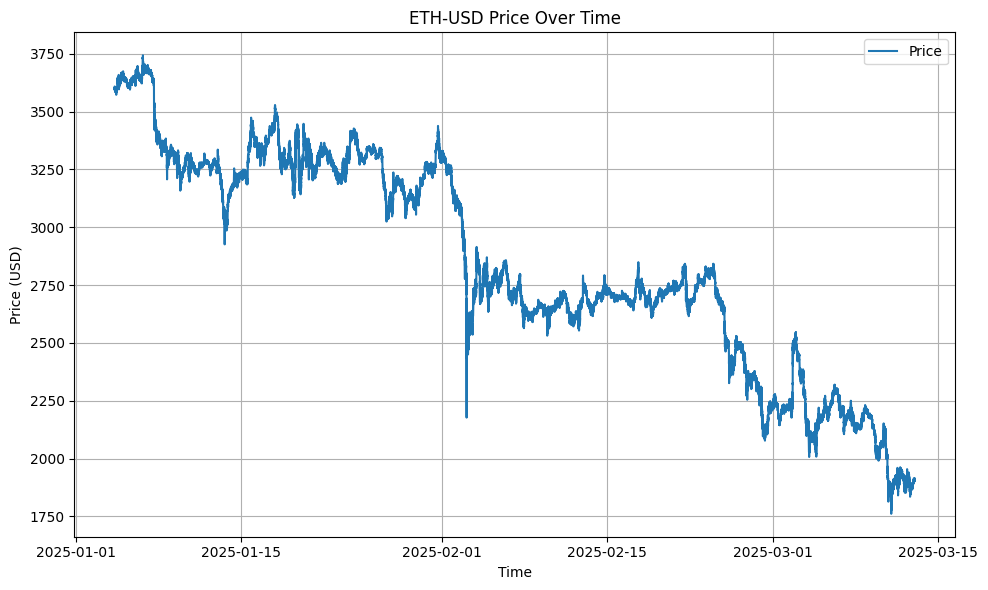

In [13]:
# Convert 'time' to datetime, coercing errors
df_trades['time'] = pd.to_datetime(df_trades['time'], errors='coerce')

# Drop rows where 'time' is NaT (invalid date)
df_trades = df_trades.dropna(subset=['time'])

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
# Compute percent difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage
df_trades['rolling_std_5'] = df_trades['price'].rolling(window=5).std().fillna(0)
df_trades['rolling_std_10'] = df_trades['price'].rolling(window=10).std().fillna(0)
df_trades['abs_pct_change'] = df_trades['pct_change'].abs()
df_trades['is_spike'] = (df_trades['abs_pct_change'] > 2).astype(int)
 
# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['price_diff'] = df_trades['price'] - df_trades['sma_5']
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,price,size,time,side,price_scaled,pct_change,rolling_std_5,rolling_std_10,abs_pct_change,is_spike,sma_5,price_diff,momentum
5,3597.69,0.003707,2025-01-04 06:40:00.442719+00:00,1.0,0.926538,-0.000556,0.198192,0.000000,0.000556,0,0.926592,3596.763408,-0.000636
6,3597.70,0.006879,2025-01-04 06:40:17.994423+00:00,0.0,0.926544,0.000278,0.011402,0.000000,0.000278,0,0.926547,3596.773453,-0.000227
7,3597.70,0.015755,2025-01-04 06:40:32.624359+00:00,0.0,0.926544,0.000000,0.011402,0.000000,0.000000,0,0.926546,3596.773454,-0.000005
8,3597.70,0.000804,2025-01-04 06:40:48.741554+00:00,0.0,0.926544,0.000000,0.007071,0.407934,0.000000,0,0.926544,3596.773456,-0.000010
9,3597.70,0.119900,2025-01-04 06:41:04.481562+00:00,0.0,0.926544,0.000000,0.004472,0.403651,0.000000,0,0.926543,3596.773457,-0.000005


In [ ]:
# Parameters
sequence_length = 10
forecast_steps = 5

# Feature prep
features = ['price_scaled']
data = df_trades[features].values

X_lstm = []
y = []

for i in range(len(data) - sequence_length - forecast_steps):
    X_lstm.append(data[i:i+sequence_length])
    y.append(data[i + sequence_length + forecast_steps - 1][0])  # Predict price_scaled

X_lstm = np.array(X_lstm)
y = np.array(y)


In [23]:
# Split into train/test
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, shuffle=False)


In [24]:
# --- LSTM Feature Extractor --- #
num_features = X_train_lstm.shape[2]
lstm_input = Input(shape=(sequence_length, num_features))
_, h, _ = LSTM(32, return_state=True)(lstm_input)
lstm_model = Model(inputs=lstm_input, outputs=h)


In [25]:
# Extract LSTM features
lstm_features_train = lstm_model.predict(X_train_lstm, verbose=0)
lstm_features_test = lstm_model.predict(X_test_lstm, verbose=0)

# Optional: also add static features from the last timestep of each sequence
static_features_train = X_train_lstm[:, -1, :]
static_features_test = X_test_lstm[:, -1, :]

X_train_combined = np.hstack((lstm_features_train, static_features_train))
X_test_combined = np.hstack((lstm_features_test, static_features_test))


In [ ]:
# --- Train LightGBM --- #
model = LGBMRegressor(
    objective='huber',
    alpha=0.9,
    max_depth=12,
    num_leaves=128,
    min_child_samples=10,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_combined)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Optional inverse scaling of predictions, if needed:
# y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1055076, number of used features: 9
[LightGBM] [Info] Start training from score 0.606857


LGBMRegressor(alpha=0.9, colsample_bytree=0.9, learning_rate=0.03, max_depth=12,
              min_child_samples=10, n_estimators=300, num_leaves=128,
              objective='huber', random_state=42, subsample=0.9)

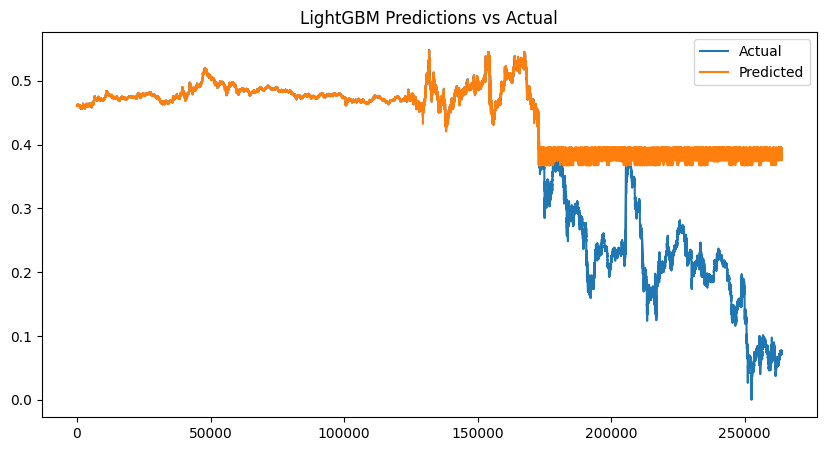

In [28]:
# Optional: plot predictions
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("LightGBM Predictions vs Actual")
plt.show()
